In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import numpy as np
from scipy.optimize import curve_fit


## The goal of this notebook is to fit to a decaying sine wave. The frequency of this oscillation will give us information about the ratio of specific heats, $\frac{C_p}{C_v}$

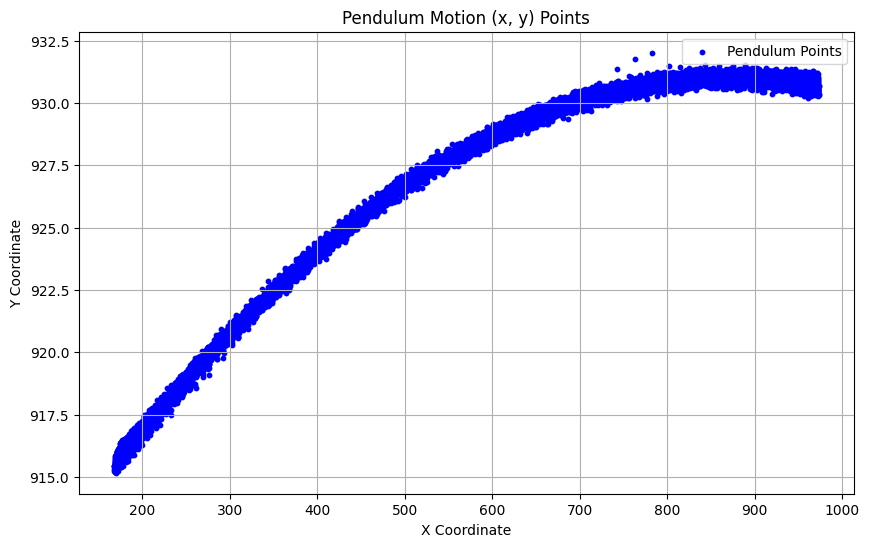

In [ ]:
# Load the CSV data containing the results
csv_file_path = '../CSV Files/YOUR_FILE_HERE' #INPUT YOUR FILE NAME HERE
data = pd.read_csv(csv_file_path)

# Extract x (x-coordinate) and y (y-coordinate)
x = data['x'].values
y = data['y'].values
time = data['Time'].values

"""If there are outliers then use the following block of code to remove them"""

#indices = y > 1 
#Extract corresponding time values
#t_values = time[indices]

#y = y[indices]
#x=x[indices]
#time = time[indices]

""" end here """

# Plot the (x, y) points
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='b', s=10, label='Steel ball')


# Add labels and title
plt.title('Steel ball Motion (x, y) Points')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Add a grid and show the plot
plt.grid(True)
plt.legend()
plt.show()


## This cell just fits the points to a circle to extract an origin point

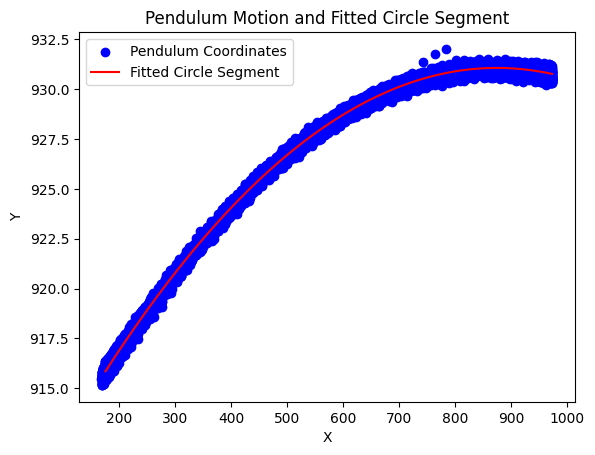

Estimated Origin (Center of Circle): (873.9999140100858, -15134.887578716864)


In [ ]:
def circle_residuals(params, x, y):
    cx, cy, r = params
    return (x - cx)**2 + (y - cy)**2 - r**2

# Initial guess for the center (cx, cy) and radius (r)
initial_guess = [np.mean(x), np.mean(y), np.std(x)]

# Use least squares to fit the circle
result = least_squares(circle_residuals, initial_guess, args=(x, y))

# Extract the center (cx, cy) and radius (r) of the fitted circle
cx, cy, r = result.x

# Generate circle points but only in the range of x and y values
theta = np.linspace(0, 2 * np.pi, 10000)
circle_x = cx + r * np.cos(theta)
circle_y = cy + r * np.sin(theta)

# **Filter the circle points to only keep those near the data points**
mask = (circle_x >= min(x)) & (circle_x <= max(x)) & (circle_y >= min(y)) & (circle_y <= max(y))
circle_x_filtered = circle_x[mask]
circle_y_filtered = circle_y[mask]

# Plot the points and the fitted partial circle
plt.scatter(x, y, label='Pendulum Coordinates', color='blue')
plt.plot(circle_x_filtered, circle_y_filtered, label='Fitted Circle Segment', color='red')
plt.figure(figsize=(10, 6))

plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.title('Pendulum Motion and Fitted Circle Segment')
plt.legend()
plt.show()

# Output the estimated origin (cx, cy)
print(f"Estimated Origin (Center of Circle): ({cx}, {cy})")

## Convert coordinates from (x,y) to (r,theta)

In [18]:

# Compute angles in radians
theta = np.arctan2(y - cy, x - cx)


# Normalize by subtracting the mean angle
theta_mid = np.mean(theta)
theta_normalized = theta - theta_mid

# Ensure angles remain within [-π, π] range
theta_normalized = np.arctan2(np.sin(theta_normalized), np.cos(theta_normalized))

# # Plot angle vs. time
# plt.figure(figsize=(10, 5))
# plt.plot(time, theta_normalized, label="Pendulum Angle (radians)", color='b')
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Midline
# plt.xlabel("Time (s)")
# plt.ylabel("Angle (radians)")
# plt.title("Pendulum Angle Over Time")
# plt.legend()
# plt.grid(True)
# plt.show()


In [19]:
# Create a DataFrame with time and normalized angle
angle_data = pd.DataFrame({
    "time": time,
    "angle": theta_normalized
})

# Save to a CSV file
angle_data.to_csv("pendulum_angles.csv", index=False)

In [ ]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

def fit_damped_oscillation(tt, yy):
    '''Fit a damped oscillation to the input time sequence, and return fitting parameters.
    
    ARGUMENTS:
        - `tt` array of time values
        - `yy` array of position values

    RETURNS:
        - Dictionary of fit paramters

    
    '''
    tt = np.array(tt)
    yy = np.array(yy)
    
    # Estimate initial guesses using FFT (for frequency) and basic statistics
    ff = np.fft.fftfreq(len(tt), tt[1] - tt[0])   # Assume uniform time spacing
    Fyy = np.abs(np.fft.fft(yy))
    guess_freq = np.abs(ff[np.argmax(Fyy[1:]) + 1])  # Ignore the zero frequency (offset) peak
    
    # Estimate amplitude and offset
    guess_amp = (np.max(yy) - np.min(yy)) / 2
    guess_offset = np.mean(yy)
    
    # Estimate damping coefficient (use a small value for initial guess)
    guess_gamma = 0.1
    
    # Guess for omega (angular frequency)
    guess_omega = 2 * np.pi * guess_freq
    guess_phi = 0  # Initial guess for phase (can be adjusted based on data)
    
    # Initial guess vector
    guess = np.array([guess_amp, guess_gamma, guess_omega, guess_phi, guess_offset])

    # Damped oscillation function to fit
    def damped_oscillation(t, A, gamma, w, phi, c):
        return A * np.exp(-gamma * t) * np.cos(w * t + phi) + c

    # Perform curve fitting
    popt, pcov = scipy.optimize.curve_fit(damped_oscillation, tt, yy, p0=guess)

    # Extract fitted parameters
    A, gamma, w, phi, c = popt
    
    # Calculate frequency and period
    f = w / (2 * np.pi)
    period = 1 / f
    
    # Return the fit parameters and the fitted function
    fitfunc = lambda t: A * np.exp(-gamma * t) * np.cos(w * t + phi) + c
    return {
        "amp": A, 
        "gamma": gamma, #THIS IS THE TIME CONSTANT NOT THE RATIO OF SPECIFIC HEATS
        "omega": w, 
        "phase": phi, 
        "offset": c, 
        "freq": f, 
        "period": period, 
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov), 
        "rawres": (guess, popt, pcov)
    }

In [4]:
import numpy as np
def Compute_Gamma(vol,mass,pressure,Area,period):
    Ratio = 4*np.pi**2*mass*vol/(Area**2*pressure*period**2)
    return Ratio

In [ ]:
# Example data (replace with your real pendulum data)
# Fit the damped oscillation
fit_results = fit_damped_oscillation(time, theta_normalized)

# Extract fitted parameters
A_fit = fit_results['amp']
gamma_fit = fit_results['gamma']
omega_fit = fit_results['omega']
phi_fit = fit_results['phase']
offset_fit = fit_results['offset']
period_fit = fit_results['period']

# Print the results
print(f"Fitted parameters: A = {A_fit:.3f}, γ = {gamma_fit:.6f}, ω = {omega_fit:.3f}, φ = {phi_fit:.3f}, Offset = {offset_fit:.3f}")
print(f"Estimated Period: {period_fit:.3f} s")

# Plot the raw data and the fitted damped curve
plt.plot(time, theta_normalized, 'bo', label="Raw Data")  # Blue dots for raw data
plt.plot(time, fit_results["fitfunc"](time), 'r-', label="Fitted Curve")  # Red line for fit
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Damped Oscillation Fit vs. Raw Data")
plt.legend()
plt.grid(True)
plt.show()
